In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from pushover import notify
from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

from vae import Flatten, UnFlatten, VAE

In [2]:
!pip install opendatasets --upgrade --quiet

In [ ]:
#c8d4a4b698159aabd5b5a2140cab0ef4

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ashishkangen
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:03<00:00, 125MB/s]


In [6]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import torch

In [8]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [9]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize((64,64)),
    T.ToTensor()]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
dataset_size=10000

animefacedataset = torch.empty(size=(dataset_size, 3, 64, 64))
print(animefacedataset.shape)
for i in range(len(train_ds)):
    if i == dataset_size:
      break
    animefacedataset[i] = train_ds[i][0]


torch.save(animefacedataset,'/content/animefacedata.pt')

torch.Size([10000, 3, 64, 64])


In [12]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_batches_trn = torch.load('/content/animefacedata.pt').to(device)

In [13]:
print(image_batches_trn.shape)

torch.Size([10000, 3, 64, 64])


In [14]:
batch_size_cfs = 50
image_batches = image_batches_trn.reshape(int(image_batches_trn.shape[0]/batch_size_cfs), batch_size_cfs, 3, 64,64)
print('image_batches.shape', image_batches.shape)

image_batches.shape torch.Size([200, 50, 3, 64, 64])


In [15]:
image_channels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [16]:
model_load = VAE(image_channels=image_channels).to(device)
#model_load = VAE(image_channels=image_channels).to('cpu')
model_load.load_state_dict(torch.load('/content/animefacedataVAE.torch', map_location=torch.device('cpu')))
#model_load.load_state_dict(torch.load('/content/animefacedataVAE.torch', map_location=torch.device('cuda')))

<All keys matched successfully>

In [18]:
latent_vectors = []
for images in image_batches:
  h=model_load.encoder(images)
  z, mu, logvar = model_load.bottleneck(h)
  latent_vectors = latent_vectors + [z]
  #latent_vectors = torch.FloatTensor(latent_vectors)
  #print(z.shape)
 


In [27]:
latent_vectors_final = torch.cat(latent_vectors, 0)

In [28]:
latent_vectors_final.shape

torch.Size([10000, 256])

In [29]:
torch.save(latent_vectors_final,'/content/latent_vectors_final.pt')

In [32]:
generated_image=model_load.decoder(model_load.fc3(latent_vectors_final[0:1]))

In [30]:
h=model_load.encoder(image_batches_trn)

In [33]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [34]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

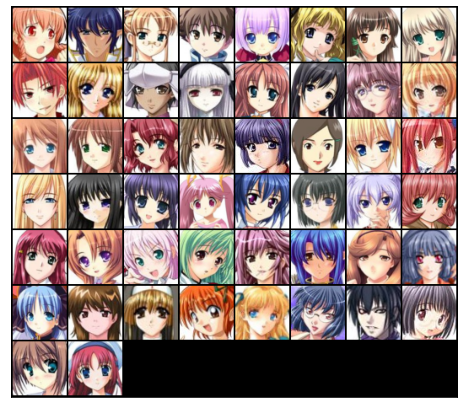

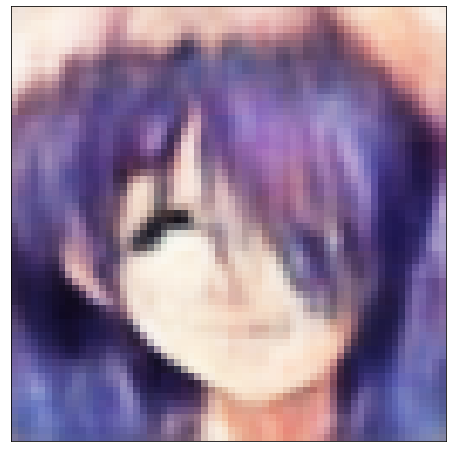

In [35]:
show_images(images.to('cpu'))
show_images(generated_image.to('cpu'), nmax=64)